### <span style="color:rgb(199,21,11)">Optimization for Machine Learning</span>

### <span style="color:rgb(199,21,11)">Master 2 IASD \& Master 2 MASH 2024-2025</span>


# <span style="color:rgb(199,21,11)">Lab 01 - Basics of gradient descent</span>

This lab session aims at illustrating the behavior of gradient descent on convex and strongly convex problems. We will first look at a toy quadratic problem, then switch to regression problems based on synthetic data.

<!--
Lecture notes for this course will be available [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/OIM/PolyOIM.pdf).
-->

This Jupyter notebook can be obtained [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/OIM/SourcesLabOIM01.zip).

For any comment regarding this notebook (including typos), please send an email to: **clement.royer@lamsade.dauphine.fr**.

#### <span style="color:rgb(199,21,11)">Preliminary remarks</span>

- This notebook and the subsequent ones used in this course mix Python code and text/LaTeX blocks. They can be run offline on any computer where Python and Jupyter are installed, or online using Google Colab (requires a Google account).

- All code blocks from this notebook are meant to be run in the order that they are given. In particular, the first block below must be run first in order to import the necessary toolboxes.

- All the notebooks from this course rely on Python and the NumPy library. A basic yet very useful tutorial on NumPy is freely available
[here](https://sebastianraschka.com/pdf/books/dlb/appendix_f_numpy-intro.pdf).

In [1]:
# Preamble: useful toolboxes, librairies, functions, etc.

# Display
%matplotlib inline
import matplotlib.pyplot as plt

from math import sqrt # Square root
from math import ceil # Ceil integer operator
from math import log # Logarithm function

# NumPy - Matrix and vector structures
import numpy as np # NumPy library
from numpy.random import multivariate_normal, randn, uniform # Probability distributions

# SciPy - Efficient mathematical calculation
from scipy.linalg import toeplitz # Toeplitz matrices
from scipy.linalg import norm # Euclidean norm
from scipy.linalg import svdvals # Singular value decomposition
from scipy.linalg import qr # QR decomposition from linear algebra
from scipy.optimize import check_grad # Numerical check of derivatives
from scipy.optimize import fmin_l_bfgs_b # An efficient minimization routine in moderate dimensions

**Useful NumPy routines (check documentation for more info)**

* *transpose* matrix (i.e. two-dimensional NumPy array) transpose operator.
* *matmul* matrix-matrix product (the two matrices should have the same number of rows/columns).
* *dot* matrix-vector product (dimensions permitting), can also be used as inner product operator between two vectors with samle length.
* *np.ones((m,n))* m-by-n matrix with all components equal to 1. 
* *np.zeros((m,n))* m-by-n matrix with all components equal to 1. 
* *np.identity(n)* square identity matrix of size n.
* *np.diag(v)* diagonal matrix defined by an array representing its diagonal elements.
* *np.pi* $\pi$ constant.
* *np.inf* represents an infinite number in memory.
* *np.log* componentwise logarithm for NumPy arrays.
* *np.exp* componentwise exponential for NumPy arrays.
* *np.sum* sum of the components of a NumPy array (for matrices, works along one dimension
* *np.maximum(u,v)* returns a NumPy array as output. The components of this array are $max(u_i,v_i)$, with $u_i$ and $v_i$ being the components of $u$ and $v$.
* *np.concatenate* concatenates NumPy arrays (vectors, matrices) of appropriate dimensions.
* If t is a NumPy array, the function *t.shape* returns the dimension(s) of that array (useful when one wants to define an array with the same dimensions.)

# <span style="color:rgb(199,21,11)">Part 1 - Gradient descent on convex and strongly convex quadratic functions</span>

## <span style="color:rgb(199,21,11)"> 1.1 - Toy quadratic problem</span>

To begin this notebook, we will study the following quadratic optimization problem:
$$
    \min_{\mathbf{x} \in \mathbb{R}^d} f(\mathbf{x}):=\tfrac{1}{2}\mathbf{x}^T \mathbf{C} \mathbf{x},
$$
where $\mathbf{C} \in \mathbb{R}^d$ is a symmetric, positive semidefinite matrix with eigenvalues
$$
    0 \le \lambda_1 \le \dots \le \lambda_d.
$$
This simple setting will allow us to illustrate the performance of gradient-type methods in a convex setting. 

### <span style="color:rgb(199,21,11)">Observations (cf September 23 lecture)</span> 

- The function is polynomial (even quadratic) in every variable, therefore it is (in particular) continuously differentiable.
- For any $\mathbf{x} \in \mathbb{R}^d$, the gradient of $f$ at $\mathbf{x}$ is given 
by $\nabla f(\mathbf{x})=\mathbf{C} \mathbf{x}$.
- The function $f$ is convex, and $\lambda_1$-strongly convex when $\lambda_1 > 0$.
- The function $f$ is $\lambda_d$-smooth, i.e. $f$ has an $\lambda_d$-Lipschitz continuous gradient.
- $\min_{\mathbf{x} \in \mathbb{R}^d} f(\mathbf{x})=0$.
- $\mathrm{argmin}_{\mathbf{x} \in \mathbb{R}^d} f(\mathbf{x})$ always contains the zero vector, and this is the only minimum when $\lambda_1 >0$.

## <span style="color:rgb(199,21,11)"> 1.2 - Two instances of the toy problem</span>

We will experiment on two different functions (hence two matrices) constructed as follows:

1) We generate a diagonal matrix $\mathbf{D}$ with eigenvalues randomly distributed in [$\mu$,$L$], where $L$ and $\mu$ are fixed, positive parameters, so as to guarantee that $\mu = \lambda_1 \le \cdots \le \lambda_d = L$.

2) We then obtain a diagonal matrix $\mathbf{D}_0$ with its $d/2$ largest eigenvalues corresponding to that of $\mathbf{D}$ and the remaining eigenvalues being equal to $0$. 

3) We generate a random orthogonal matrix $\mathbf{Q}$ and define 
$$
    \mathbf{C}_{\mu}=\mathbf{Q}^T \mathbf{D} \mathbf{Q} 
    \quad \mathrm{and} \quad
    \mathbf{C}_0=\mathbf{Q}^T \mathbf{D}_0 \mathbf{Q}.
$$

It follows that $\mathbf{C}_{\mu} \succeq \mu \mathbf{I}$, i.e. this matrix is positive definite, while $\mathbf{C}_0$ is only positive semidefinite.

In [2]:
# Defining two quadratic problems through (random) matrices

# Problem size
d=100

# Lipschitz constant
L=1

# Strong convexity constant
mu=0.01

# Fix random seed for reproducibility
np.random.seed(1)

# Generate a random orthogonal matrix Q
M = np.random.multivariate_normal(np.zeros(d),np.identity(d),size=d)
Q,R = qr(M) # Q is orthogonal by definition of the QR factorization

# Generate random eigenvalues between mu and L (procedure used for a better spread of the eigenvalues)
D = np.random.uniform(mu,L,d)
D = 10.**D
D = (D-min(D))/(max(D)-min(D))
D = mu+(L-mu)*D

D0 = D.copy()
D0[ceil(d/2):] = 0


# Produce matrix Cmu
Cmu = Q.T @ np.diag(D) @ Q

# Produce matrix A0 by setting the last eigenvalue to 0
C0 = Q.T @ np.diag(D0) @ Q

## <span style="color:rgb(199,21,11)">1.2 - Gradient descent</span>

We now define a gradient descent algorithm dedicated to our problem of interest. For simplicity, the method will use a constant stepsize, to be given as an input. Rather than aiming for a point with a gradient norm smaller than a given tolerance, we run the algorithm for a fixed number of iterations.

### <span style="color:rgb(199,21,11)">Question 1</span> 

**Fill out the missing parts in the code below. Make sure the variables you use are consistent with that of the overall code.**

In [3]:
def gd_quad(x0,C,stepsize,n_iter=100, verbose=False): 
    """
        A code for gradient descent on quadratic functions.
        
        Inputs:
            x0: Initial vector
            A: Square matrix of same
            stepsize: Value of the (constant) stepsize
            n_iter: Number of iterations
            verbose: Boolean value indicating whether the outcome of every iteration should be displayed
      
        Outputs:
            w_output: Final iterate of the method
            objvals: History of function values (output as a Numpy array of length n_iter+1)
            
    """
    
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    # Initial value of current iterate   
    x = x0.copy()

    # Initialize iteration counter
    k=0    
    
    ##########################################
    # FILL OUT THE MISSING LINE
    ##########################################

    # Current value for the objective function
    obj = 0.5*x.dot(C.dot(x))
    
    objvals.append(obj)

    # Plot the initial values if asked to
    if verbose:
        print("Gradient Descent:")
        print(' | '.join([name.center(8) for name in ["iter", "fval"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8)]))
    
    ####################
    # Main loop
    while (k < n_iter):
        
        ##################################
        # FILL OUT THE MISSING PIECES!
        ##################################
        
        # Compute the new iterate through a gradient step
        x[:] = x - stepsize*(C.dot(x))
        
        # Compute the new objective value 
        obj = 0.5*x.dot(C.dot(x))
        
        ##################################
        # END FILL-OUT SECTION
        ##################################
        objvals.append(obj)
        
        # Plot relevant information if asked to
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8)]))       
        
        # Increment the iteration count
        k += 1
    
    # End main loop
    ######################
    
    # Output
    x_output = x.copy()
    return x_output, np.array(objvals)

### <span style="color:rgb(199,21,11)">Question 2 - Tests on the strongly convex quadratic problem</span>

**In this question, we consider the matrix $\mathbf{C}_{\mu}$ generated above, and the associated quadratic problem.**

**a) Run gradient descent using a fixed initial point (e.g. the vector of all ones) for 100 iterations using 5 different values for the 
stepsize (suggested: a value > 1, 1, 3 values <1 including). Can you find a stepsize greater than $1$ for which the method seems to converge/diverge? Can you find a stepsize smaller than $1$ for which the method does not appear to converge? What about the value $1$?**

**b) Repeat the experiment of question a) using $1000$ iterations instead. Do you observe any change in the ranking of all variants?**

**c) The choice $\frac{2}{\mu+L}$ is known to be optimal stepsize for quadratics that are both $L$-smooth and $\mu$-strongly convex. Do you observe this in your experiments?**

a) It seems that, stepsize > 2.0 the method diverges and stepsize < 2.0 the method converges. Any value <= 1 converges. 

b) The ranking changes. 

c) Yes, on 1000 iter we can see that $\frac{2}{\mu+L}$ has the best result.


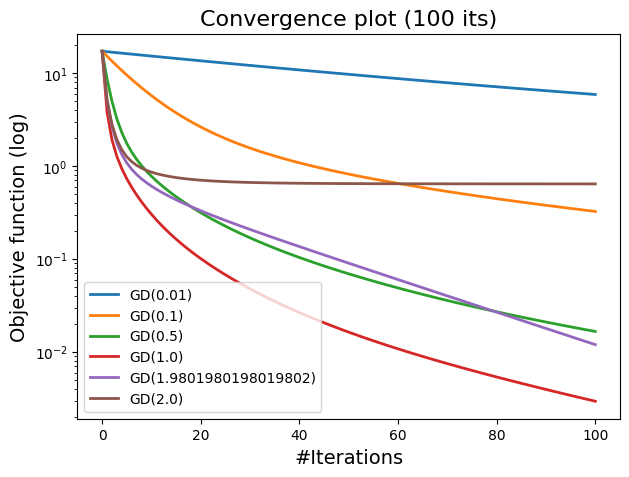

In [20]:
# Answer to question 2.a) - Suggested code template

#########################################################
# Running the variants with same initial point and budget
#########################################################

######################################
# PICK AN INITIAL POINT AND AN ITERATION BUDGET
x_0 = np.ones(d)
n_iter = 100
######################################
# CHOOSE YOUR PREFERRED VALUES FOR THE STEPSIZE
vals_stepsize = [2.0, 1.0, 0.5, 0.1, 0.01]
vals_stepsize.sort()
#
nvals = len(vals_stepsize)

objs = np.zeros((n_iter+1,nvals))

for i_val in range(nvals):
    _, objs[:,i_val] = gd_quad(x_0,Cmu,vals_stepsize[i_val],n_iter, verbose=False)


########################
# Plotting the comparison
#########################
# The x-axis corresponds to the number of iterations
# The y-axis corresponds to the function value
plt.figure(figsize=(7,5))
plt.set_cmap("RdPu")
for i_val in range(nvals):
    plt.semilogy(objs[:,i_val], label="GD("+str(vals_stepsize[i_val])+")", lw=2)
plt.title("Convergence plot ("+str(n_iter)+" its)", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function (log)", fontsize=14)
plt.legend(loc=3)

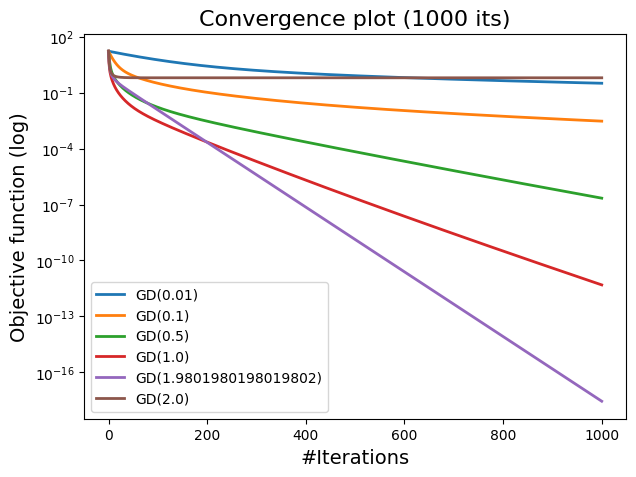

In [22]:
# Answer to question 2.b and 2.c


#########################################################
# Running the variants with same initial point and budget
#########################################################

######################################
# PICK AN INITIAL POINT AND AN ITERATION BUDGET
x_0 = np.ones(d)
n_iter = 1000
######################################
# CHOOSE YOUR PREFERRED VALUES FOR THE STEPSIZE
vals_stepsize = [2.0, 1.0, 0.5, 0.1, 0.01, 2/(L+mu)]
vals_stepsize.sort()
#
nvals = len(vals_stepsize)

objs = np.zeros((n_iter+1,nvals))

for i_val in range(nvals):
    _, objs[:,i_val] = gd_quad(x_0,Cmu,vals_stepsize[i_val],n_iter, verbose=False)


########################
# Plotting the comparison
#########################
# The x-axis corresponds to the number of iterations
# The y-axis corresponds to the function value
plt.figure(figsize=(7,5))
plt.set_cmap("RdPu")
for i_val in range(nvals):
    plt.semilogy(objs[:,i_val], label="GD("+str(vals_stepsize[i_val])+")", lw=2)
plt.title("Convergence plot ("+str(n_iter)+" its)", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function (log)", fontsize=14)
plt.legend(loc=3)


### <span style="color:rgb(199,21,11)">Question 3 - Tests on the convex quadratic problem</span>

**In this question, we consider the matrix $\mathbf{C}_0$ generated above, and the associated quadratic problem.**

**a) Run gradient descent using a fixed initial point (e.g. the vector of all ones) for 100 iterations using 5 different multiples of $1/L$, including $1/L$ itself. What value emerges as the best one?**

**b) Compare the rate of convergence on gradient descent with stepsize $1/L$ on this example with that of gradient descent with the same stepsize choice on the strongly convex problem defined by $\mathbf{C}_{\mu}$.**

a) 1/L emerges as the best one.

b) 

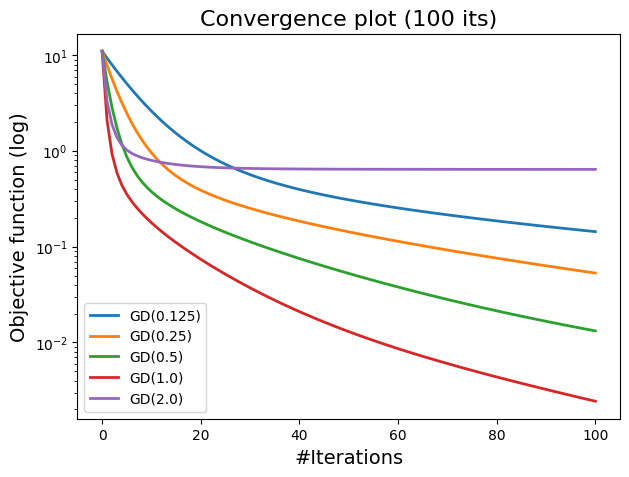

In [24]:
#########################################################
# Running the variants with same initial point and budget
#########################################################

######################################
# PICK AN INITIAL POINT AND AN ITERATION BUDGET
x_0 = np.ones(d)
n_iter = 100
######################################
# CHOOSE YOUR PREFERRED VALUES FOR THE STEPSIZE
vals_stepsize = [2/L, 1/L, 1/(2*L), 1/(4*L), 1/(8*L)]
vals_stepsize.sort()
#
nvals = len(vals_stepsize)

objs = np.zeros((n_iter+1,nvals))

for i_val in range(nvals):
    _, objs[:,i_val] = gd_quad(x_0,C0,vals_stepsize[i_val],n_iter, verbose=False)


########################
# Plotting the comparison
#########################
# The x-axis corresponds to the number of iterations
# The y-axis corresponds to the function value
plt.figure(figsize=(7,5))
plt.set_cmap("RdPu")
for i_val in range(nvals):
    plt.semilogy(objs[:,i_val], label="GD("+str(vals_stepsize[i_val])+")", lw=2)
plt.title("Convergence plot ("+str(n_iter)+" its)", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function (log)", fontsize=14)
plt.legend(loc=3)



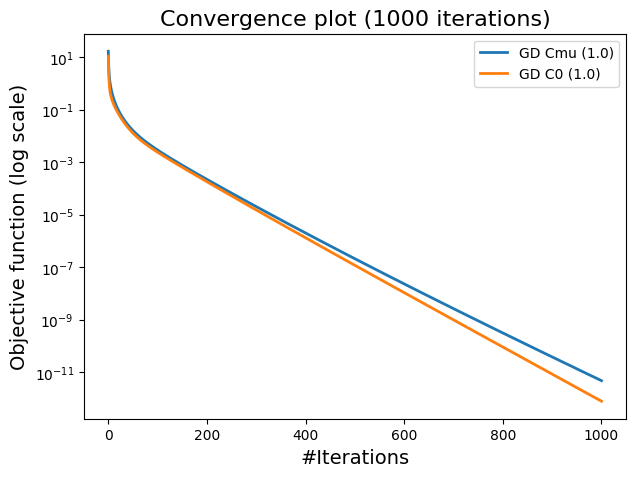

In [30]:
# Answer to question 3.b

#########################################################
# Running the variants with same initial point and budget
#########################################################

######################################
# PICK AN INITIAL POINT AND AN ITERATION BUDGET
x_0 = np.ones(d)
n_iter = 1000
######################################
# CHOOSE YOUR PREFERRED VALUES FOR THE STEPSIZE
vals_stepsize = [1/L]
vals_stepsize.sort()
#
nvals = len(vals_stepsize)

objs_Cmu = np.zeros((n_iter+1, nvals))
objs_C0 = np.zeros((n_iter+1, nvals))

for i_val in range(nvals):
    # Run gradient descent on Cmu
    _, objs_Cmu[:, i_val] = gd_quad(x_0, Cmu, vals_stepsize[i_val], n_iter, verbose=False)
    
    # Run gradient descent on C0
    _, objs_C0[:, i_val] = gd_quad(x_0, C0, vals_stepsize[i_val], n_iter, verbose=False)

########################
# Plotting the comparison
#########################
# The x-axis corresponds to the number of iterations
# The y-axis corresponds to the function value
plt.figure(figsize=(7, 5))
plt.set_cmap("RdPu")

# Plot the results for Cmu
for i_val in range(nvals):
    plt.semilogy(objs_Cmu[:, i_val], label="GD Cmu ("+str(vals_stepsize[i_val])+")", lw=2)

# Plot the results for C0
for i_val in range(nvals):
    plt.semilogy(objs_C0[:, i_val], label="GD C0 ("+str(vals_stepsize[i_val])+")", lw=2)

plt.title("Convergence plot ("+str(n_iter)+" iterations)", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function (log scale)", fontsize=14)
plt.legend(loc='best')
plt.show()


# <span style="color:rgb(199,21,11)">Part 2 - Convex Empirical Risk Minimization</span>

We now consider empirical risk minimization problems, that are at the center of this course. We will study the performance of gradient descent on two finite-sum problems based on learning a linear model from synthetic data. This will require a more generic implementation of gradient than that from the first part of this notebook.

## <span style="color:rgb(199,21,11)">2.1 - Generating the data</span>

We consider a dataset $\{(\mathbf{a}_i,y_i)\}_{i=1,\dots,n}$, where $\mathbf{a}_i \in \mathbb{R}^d$ and $y_i \in \mathbb{R}$, available in the form of:

- a feature matrix $\mathbf{A} \in \mathbb{R}^{n \times d}$;
- and a vector of labels $\mathbf{y} \in \mathbb{R}^n$. 

Given this dataset, we will seek a linear model parameterized by a vector $\mathbf{x}$ that explains the data according to a certain loss function $\ell$. This results in the following formulation:
$$
    \min_{\mathbf{x} \in \mathbb{R}^d} f(\mathbf{x}) = \frac{1}{n} \sum_{i=1}^n f_i(\mathbf{x}), \qquad f_i(\mathbf{x}) = \ell(\mathbf{a}_i^T\mathbf{x},y_i) + \frac{\lambda}{2}\|\mathbf{x}\|^2.
$$
where $\lambda \ge 0$ is an optional regularization parameter *(more on this in the lectures on regularization)*.

The dataset will be produced according to the procedure below.

In [ ]:
# Data generation.
# This code is inspired by a generator proposed by A. Gramfort from INRIA.

def simu_linmodel(x, n, std=1., corr=0.5):
    """
    Simulation values obtained by a linear model with additive noise
    
    Parameters
    ----------
    x : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the feature matrix
    """    
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    y = A.dot(x) + noise
    return A, y

The data is thus produced from a linear model corrupted with noise: $\mathbf{y} = \mathbf{A} \mathbf{x}^* + \mathbf{\epsilon}$, where $\mathbf{\epsilon}$ follows a Gaussian distribution. Our goal will thus be to learn a linear model from the data.

## <span style="color:rgb(199,21,11)">2.2 Linear regression</span>

In *linear regression*, we seek a linear model that explains the data based on minimizing a least-squares objective:
$$
    \mathrm{minimize}_{\mathbf{x} \in \mathbb{R}^d} f(\mathbf{x}) 
    := \frac{1}{2 n} \|\mathbf{A} \mathbf{x} - \mathbf{y}\|^2 + \frac{\lambda}{2}\|\mathbf{x}\|^2 
    = \frac{1}{n} \left(\frac{1}{2}\sum_{i=1}^n (\mathbf{a}_i^T \mathbf{x} - y_i)^2 + \frac{\lambda}{2}\|\mathbf{x}\|^2 \right)
$$ 
for some $\lambda \ge 0$.

### <span style="color:rgb(199,21,11)">Observations</span> 

- The function $f$ is quadratic.
- The function $f$ is $L$-smooth with $L = \frac{\|\mathbf{X}^T \mathbf{X}\|}{n}+\lambda$. 
- The function $f$ is convex, and $(\sigma_{\min}(A)+\lambda)$-strongly convex when $\sigma_{\min}(A)+\lambda>0$, where $\sigma_{\min}(A)$ denotes the minimum singular value of $A$.

## <span style="color:rgb(199,21,11)">2.3 Logistic regression</span>

In *logistic regression*, we still consider a linear model, but for classification purposes (here $y_i \in \{-1,1\}$). We use a loss function better suited for classification:
$$
    \mathrm{minimize}_{\mathbf{x} \in \mathbb{R}^d} f(\mathbf{x}) 
    := \frac{1}{n} \sum_{i=1}^n f_i(\mathbf{x}), \qquad 
    f_i(\mathbf{x})=\log(1+\exp(-y_i \mathbf{a}_i^T \mathbf{x}))+\frac{\lambda}{2}\|\mathbf{x}\|^2,
$$
where $\lambda \ge 0$ is a regularization parameter.

### <span style="color:rgb(199,21,11)">Observations</span> 

- For any $\mathbf{x} \in \mathbb{R}^d$, one has
$$
\nabla f(\mathbf{x}) = \frac{1}{n}\sum_{i=1}^n  -\frac{y_i}{1 + \exp(y_i \mathbf{a}_i^T \mathbf{x})} \mathbf{a}_i + \lambda \mathbf{x}.
$$
- The function $f$ is convex and even $\lambda$-strongly convex when $\lambda>0$.
- The function $f$ is $L$-smooth with $L =\frac{\|\mathbf{A}^T \mathbf{A}\|}{4n}+\lambda$.

## <span style="color:rgb(199,21,11)">2.4 Python class for regression problems</span>

### <span style="color:rgb(199,21,11)">Question 4</span> 

**Fill out the missing parts in the code below to encode the objective and the gradient of both regression problems, using the formulae from Sections 2.2 and 2.3. Run the next two blocks to check correctness of your implementation.**

*Useful functions:* For any matrix/2-way Numpy array A,

- A.dot(v) is the matrix-vector product $A v$ (if A is a vector, this returns the scalar product);
- A.T is the transpose matrix $A^T$.

- np.log : logarithm applied componentwise on Numpy arrays.
- np.mean : average of the components of a NumPy array

In [ ]:
# Python class for regression problems
class RegPb(object):
    '''
        A class for regression problems with linear models.
        
        Attributes:
            A: Data matrix (features)
            y: Data vector (labels)
            n,d: Dimensions of A
            loss: Loss function to be considered in the regression
                'l2': Least-squares loss
                'logit': Logistic loss
            lbda: Regularization parameter
    '''
   
    # Instantiate the class
    def __init__(self, A, y,lbda=0,loss='l2'):
        self.A = A
        self.y = y
        self.n, self.d = A.shape
        self.loss = loss
        self.lbda = lbda
        
    
    ###############################################################
    # PARTS TO BE FILLED OUT BELOW
    ###############################################################
    
    # Objective value
    def fun(self, x):
        

    
    # Full gradient computation
    def grad(self, x):
        
    
    ###############################################################
    # NOTHING MORE TO FILL OUT PAST THIS POINT
    ###############################################################

    # Lipschitz constant for the gradient
    def lipgrad(self):
        if self.loss=='l2':
            L = norm(self.A, ord=2) ** 2 / self.n + self.lbda
        elif self.loss=='logit':
            L = norm(self.A, ord=2) ** 2 / (4. * self.n) + self.lbda
        return L
    
    # ''Strong'' convexity constant (could be zero if self.lbda=0)
    def cvxval(self):
        if self.loss=='l2':
            s = svdvals(self.A)
            mu = min(s)**2 / self.n # More efficient than computing ||A^T A||
            return mu + self.lbda
        elif self.loss=='logit':
            return self.lbda

The first script below generates two problem instances (one for each class), the second checks the implementation of the derivatives, and the third one computes an approximate solution for each problem.

In [ ]:
# Generate the problem instances - we use moderate sizes but those will serve our purpose

d = 50
n = 1000
idx = np.arange(d)
lbda = 1. / n ** (0.5)

# Fix random seed for reproducibility
np.random.seed(1)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

Alin, ylin = simu_linmodel(x_model_truth, n, std=1., corr=0.1)
Alog, ylog = simu_linmodel(x_model_truth, n, std=1., corr=0.7)
ylog = np.sign(ylog) # Taking the logarithm for binary classification

pblinreg = RegPb(Alin, ylin,lbda,loss='l2')
pblogreg = RegPb(Alog, ylog,lbda,loss='logit')

The next code block aims at validating the implementation of the gradient.

In [ ]:
# Check correctness of the gradient functions compared to a finite-difference estimate
# Note: this is a check of the implementation of the gradient and the function value. If correct, the 
# output value, which represents the difference between a gradient and its estimation from function values, 
# should be of order 1e-06 at most.
# (See the lecture by Gabriel Peyré on automatic differentiation)

# Check for the linear regression problem
print("Linear regression gradient error:",check_grad(pblinreg.fun, pblinreg.grad, np.random.randn(d)))

# Check for the logistic regression problem
print("Logistic regression gradient error:",check_grad(pblogreg.fun, pblogreg.grad, np.random.randn(d)))

## <span style="color:rgb(199,21,11)">2.5 Numerical estimates of $\min$ and $\mathrm{argmin}$</span>

In this lab, we work with relatively simple loss functions (and a moderate number of data points): we can thus efficiently compute a solution using a second-order method. This provides us with a target objective value as well as a target vector of weights.

In [ ]:
# Use L-BFGS-B to determine a solution for both problems

x_init = np.zeros(d)
# Compute the optimal solution for linear regression
x_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, x_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)
print("Linear regression:")
print("\t Numerical minimal value:",f_min_lin)
print("\t Numerical minimum gradient norm:",norm(pblinreg.grad(x_min_lin)))

# Compute the optimal solution for logistic regression
x_min_log, f_min_log, _ = fmin_l_bfgs_b(pblogreg.fun, x_init, pblogreg.grad, args=(), pgtol=1e-30, factr =1e-30)
print("Logistic regression:")
print("\t Numerical minimal value:",f_min_log)
print("\t Numerical minimum gradient norm:",norm(pblogreg.grad(x_min_log)))

These solutions will enable us to study the behavior of the distance to optimality in terms of function values 
$f(\mathbf{x}_k)-f^*$ and iterates $\|\mathbf{x}_k -\mathbf{x}^*\|$. 

*Note: Recall that $\|\nabla f(\mathbf{x}_k)\| \ge 2 \mu (f(\mathbf{x}_k)-f^*)$ for a $\mu$-strongly convex, continuously differentiable function with optimal value $f^*$, thus the gradient could also be used as an upper estimate of the distance to optimality in terms of function values.*

## <span style="color:rgb(199,21,11)">2.6 Gradient descent implementation</span>

We will investigate several techniques for selecting the stepsize in a predetermined or adaptive fashion in gradient descent. Those are by no means exhaustive, but give a nice overview of existing options (see upcoming lectures for more details about the theory behind those methods). We will consider the three following options:

- *Constant stepsize:* $\alpha_k = \frac{\bar{\alpha}}{L}$, where $L$ is the Lipschitz constant for $\nabla f$ (assumed to be known in that case).

- *Decreasing stepsize:* $\alpha_k = \frac{\bar{\alpha}}{(k+1)^a}$, where $a>0$ is given as input

- *Armijo-type line search:* $\alpha_k=\frac{\bar{\alpha}}{2^{j_k}}$, where $j_k$ is the smallest nonnegative integer such that
$$
f\left(\mathbf{x}_k-\frac{\bar{\alpha}}{2^{j_k}}\nabla f(\mathbf{x}_k)\right) < f(\mathbf{x}_k) - 0.0001 \frac{\alpha}{2^{j_k}}\|\nabla f(\mathbf{x}_k)\|^2.
$$
In practice, the line search should stop if the decrease condition is satisfied or $\frac{\bar{\alpha}}{2^{j_k}} < 10^{-10}$. Note that the parameters $2$,$0.0001$ and $10^{-10}$ are set for simplicity.


### <span style="color:rgb(199,21,11)">Question 5</span>

**Fill out the function template below with the gradient descent iteration and the three rules for the stepsize above (that are encoded using input parameters).**

In [ ]:
# Gradient descent
def gd_reg(x0,problem,xopt,stepchoice=0,stepbar=1, n_iter=1000, verbose=False): 
    """
        An implementation of gradient descent with several stepsize rules.
        
        Inputs:
            x0: Initial point
            problem: Problem structure
                problem.fun(x) Objective value
                problem.grad(x) Gradient
                problem.lipgrad() Lipschitz constant for the gradient
            xopt: Target point for the optimization (approximate optimum computed beforehand)
            stepchoice: Rule for choosing the stepsize (see above)
                0: Constant equal to 1/L where L is a Lipschitz constant for the gradient
                a>0: Decreasing, set to 1/((k+1)**a)
                -1: Armijo line search
            stepbar: Initial step size (used when stepchoice = 1)
            n_iter: Maximum iteration number
            verbose: Boolean value indicating whether iteration-level information should be displayed.
      
        Outputs:
            w_output: Last iterate of the method
            objvals: History of function values (Numpy array of length n_iter)
            distits: History of distances to the target point (Numpy array of length n_iter)
            ngvals: History of gradient norms (Numpy array of length n_iter)
            
    """
    
    ############
    # Initialization

    # History of function values
    objvals = []
    
    # History of gradient norms
    ngvals = []
    
    # History of distances to the target
    distits = []
    
    # Lipschitz constant
    L = problem.lipgrad()
    
    # Initial value of the incumbent, a.k.a. current iterate
    x = x0.copy()

    # Initialize the iteration count
    k=0    
    
    # Initial function value
    obj = problem.fun(x) 
    objvals.append(obj);
    
    # Initial gradient
    g = problem.grad(x)
    ng = norm(g)
    ngvals.append(ng)
    
    # Distance between the current point and the optimal point
    dist = norm(x-xopt)
    distits.append(dist)

    # Plot initial values 
    if verbose:
        print("Gradient descent:")
        print(' | '.join([name.center(8) for name in ["iter", "fval", "dist","stepsize"]]))
    
    ####################
    # Main loop
    while (k < n_iter):
        
        #####################################################################################
        ###### THIS PART SHOULD BE FILLED WITH THE ACTUAL STEPSIZE CALCULATION AND ITERATION
        
        # 1 - Define the stepsize s based on k (iteration index), L (Lipschitz constant), step0 (initial value)
        # and g (the function)
        
        
        # 2 - Perform the gradient descent iteration using the stepsize s and the gradient g
        x[:] = 
      
            
        ###### NOTHING MORE TO FILL PAST THIS POINT. 
        ###### MAKE SURE THAT x NOW CONTAINS THE NEXT ITERATE AND s THE ASSOCIATED STEPSIZE
        ####################################################################################
        
        
        # Plot relevant information
        if verbose:        
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % dist).rjust(8),("%.2e" % s).rjust(8)]))
        
        # Compute values associated with the next iterate
        obj = problem.fun(x)
        objvals.append(obj)
        g = problem.grad(x)
        ng = norm(g)
        ngvals.append(ng)
        dist = norm(x-xopt)
        distits.append(dist)
        
        # Increase iteration counter
        k += 1
    
    # End main loop
    ######################
    
    # Outputs
    x_output = x.copy()
    return x_output, np.array(objvals), np.array(distits), np.array(ngvals)

### <span style="color:rgb(199,21,11)">Question 6</span>

**a) Run gradient descent when using the four following rules on linear regression:**

- $\alpha_k = \frac{1}{L}$;

- $\alpha_k = \frac{1}{k+1}$;

- $\alpha_k = \frac{1}{\sqrt{k+1}}$;

- $\alpha_k$ **chosen through Armijo line search with $\bar{\alpha}=1$.**

**Compare the convergence curves in terms of (log of) function values $\{f(x_k)\}$ and $\{f(x_k)-f^*_{lin}\}$, where 
$f^*_{lin}$ is the value computed in Section 2.5.**

**b) Plot the gradient norms and the distances to optimum as a function of the number of iterations. Are those plots consistent with the others? Do they bring additional insights about the methods?**

**c) What other curves and/or quantities could you plot for comparing those four variants, so that the comparison is the fairest possible?** 

In [ ]:
# Answer to Question 6a)b)c)


### <span style="color:rgb(199,21,11)">Question 7</span>

**Repeat the experiments of Question 6 using logistic regression. Try to find the best possible rule for the stepsize.**

In [ ]:
# Answer to question 6)d)


In [ ]:
# Version 1.0 - C. W. Royer, September 2024.